# (Try to) identify signals of gentrification from Airbnb data

In [5]:
import os
import re
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from shapely.geometry import Point
from PlottingFunctions import *

cmap = plt.get_cmap('plasma', 5)  # 5 discrete colors
plot_colors = [cmap(i) for i in range(5)]
plot_colors[4] = 'gold'

### Running for Bristol 

For Bristol there should be 1495 rows in the results. There are 2644 rows in the original listings file, but 1149 of them have no description for the neighbourhood overview or 

In [4]:
city='bristol'
lsoas =  gpd.read_file('../../data/Bristol_LSOAs/Lower_Layer_Super_Output_Areas_2011_(Precise).shp')

In [ ]:
base_dir = os.path.expanduser(f"../data/airbnb-{city}/")
gentrication_cat_df = pd.read_csv(base_dir + 'airbnb_gentrification_scores_categorical_01.csv')
overall_df = gentrication_cat_df

### Convert to geodataframe

In [ ]:
overall_df['geometry'] = overall_df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
overall_gdf = gpd.GeoDataFrame(overall_df, geometry='geometry', crs="EPSG:4326")
overall_gdf = overall_gdf.to_crs(lsoas.crs)
overall_gdf = gpd.sjoin(overall_gdf, lsoas[['LSOA11NM', 'geometry']], how='left', predicate='within')

### Add:
- Word instead of code

In [ ]:
mapping = {'Na': 0,'Undeveloped': 1, 'Emerging': 2, 'Gentrifying': 3, 'Established': 4}
overall_gdf['gentrification_prediction_code'] = overall_gdf['gentrification_prediction'].map(mapping)

In [ ]:
lsoa_scores_gentrification = overall_gdf.groupby("LSOA11NM")["gentrification_prediction_code"].agg(lambda x: pd.Series.mode(x).iloc[0])
lsoas = lsoas.merge(lsoa_scores_gentrification, on='LSOA11NM', how='left')
lsoas = lsoas.sort_values(by='LSOA11NM')

### Read in socio-economic data

In [ ]:
indicators = pd.read_csv("../data/SocioEconomicData/Eng_imputedV3.csv")
indicators_bristol = indicators[indicators['LA_NAME'] =='Bristol, City of'].copy()
indicators_bristol = indicators_bristol.rename(columns={"LSOA": 'LSOA11CD'})
indicators_bristol = indicators_bristol.merge(lsoas[['LSOA11CD', 'gentrification_prediction_code']], on='LSOA11CD', how='left')
indicators_bristol.sort_values(by='gentrification_prediction_code', inplace=True)

### Rescale values between 0 and 1

In [ ]:
numeric_cols = indicators_bristol.columns
numeric_cols = numeric_cols.drop(['LSOA11CD', 'LA_NAME', 'gentrification_prediction_code'])
indicators_bristol[numeric_cols] = (indicators_bristol[numeric_cols] - indicators_bristol[numeric_cols].min()) / \
                                   (indicators_bristol[numeric_cols].max() - indicators_bristol[numeric_cols].min())

### Create version with the mean across years

In [ ]:
indicators_bristol_short = indicators_bristol.copy()

# Dictionary of variable prefixes and their year ranges
variables = {'PROF2POP': range(2010, 2021),'Churn': range(2008, 2021), 'NINO': range(2008, 2021), 'JSA': range(2008, 2021),'HP': range(2008, 2021)}

# Loop over each variable type to compute mean
for var, years in variables.items():
    cols = [f"{var}_{year}" for year in years]
    indicators_bristol_short[f'{var}_mean'] = indicators_bristol_short[cols].mean(axis=1)
    # To also compute std, uncomment the line below
    # indicators_bristol_short[f'{var.lower()}_std'] = indicators_bristol_short[cols].std(axis=1)

# Drop all original year columns
all_cols = [f"{var}_{year}" for var, years in variables.items() for year in years]
indicators_bristol_short.drop(columns=all_cols, inplace=True)

### Create version with just one of each variable 'group'

In [ ]:
variables = ['NINO_mean', 'Churn_mean', 'JSA_mean', 'HP_mean', 'PROF2POP_mean']

# Example usage for creating plots
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'},figsize=(3,4), sharex=True, sharey=True)

for gentr_class, val in enumerate(np.unique(indicators_bristol_short['gentrification_prediction_code'])):
    class_data = indicators_bristol_short[indicators_bristol_short['gentrification_prediction_code'] == gentr_class]
    if len(class_data)>0:
        plot_mean_rose_plot(ax, class_data, plot_colors[gentr_class], just_means=True)

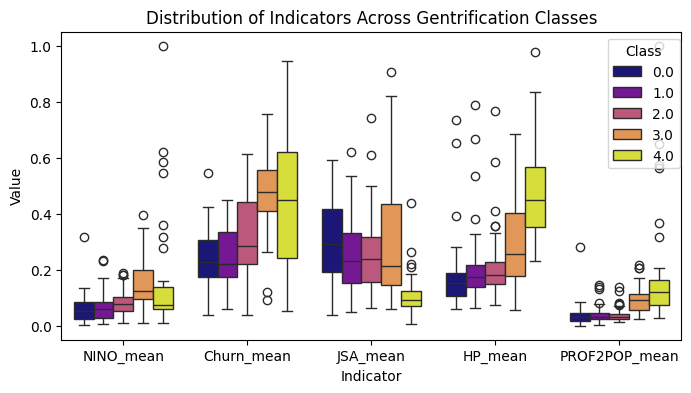

In [30]:
# Melt the dataframe to long format for seaborn
variables = ['NINO_mean', 'Churn_mean', 'JSA_mean', 'HP_mean', 'PROF2POP_mean']

# Select relevant columns + gentrification class
df_melted = indicators_bristol_short[['gentrification_prediction_code'] + variables].melt(id_vars='gentrification_prediction_code', 
                                     value_vars=variables, var_name='Indicator',  value_name='Value')

plt.figure(figsize=(8, 4))
sns.boxplot(data=df_melted, 
            x='Indicator', 
            y='Value', 
            hue='gentrification_prediction_code', 
            palette='plasma')  # or any nice palette like 'Set2', 'coolwarm'

plt.title('Distribution of Indicators Across Gentrification Classes')
plt.legend(title='Class', bbox_to_anchor=(0.87, 1), loc='upper left')

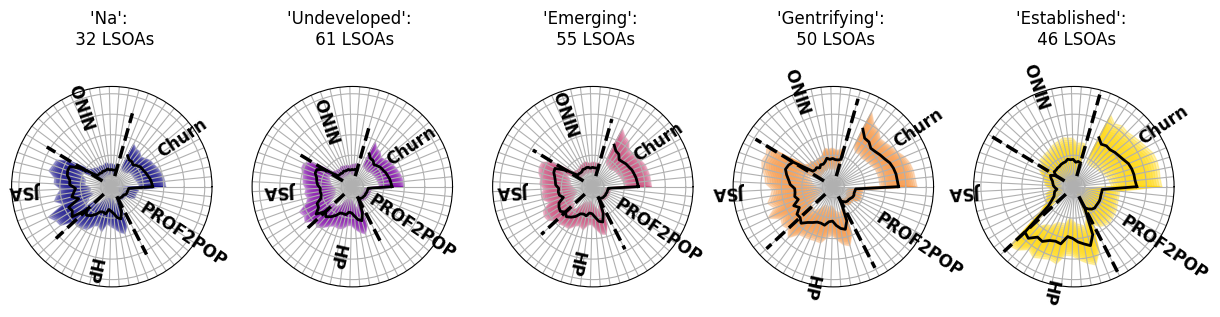

In [13]:
variables = indicators_bristol.columns
to_be_removed = {'LSOA11CD', 'LA_NAME', 'gentrification_prediction_code'}
variables = [item for item in variables if item not in to_be_removed ]

fig, axs = plt.subplots(subplot_kw={'projection': 'polar'}, ncols=5, nrows=1, figsize=(15,10), sharex=True, sharey=True)

for gentr_class, ax in enumerate(axs.flatten()):
    class_data = indicators_bristol[indicators_bristol['gentrification_prediction_code'] == gentr_class]
    if len(class_data) == 0:
        ax.set_axis_off()
    else:
        plot_mean_rose_with_group_labels(ax, class_data, plot_colors[gentr_class],variables)
        key = [k for k, v in mapping.items() if v == gentr_class][0]
        ax.set_title(f"'{key}': \n {len(class_data)} LSOAs", size=12, pad=30)

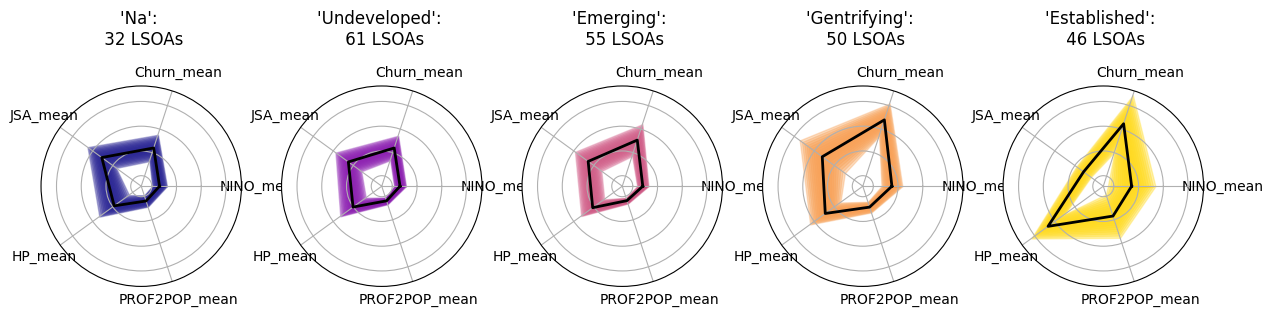

In [14]:
variables = ['NINO_mean', 'Churn_mean', 'JSA_mean', 'HP_mean', 'PROF2POP_mean']

fig, axs = plt.subplots(subplot_kw={'projection': 'polar'}, ncols=5, nrows=1, figsize=(15,10), sharex=True, sharey=True)

for gentr_class, ax in enumerate(axs.flatten()):
    class_data = indicators_bristol_short[indicators_bristol_short['gentrification_prediction_code'] == gentr_class]
    if len(class_data) == 0:
        ax.set_axis_off()
    else:
        plot_mean_rose_plot_with_gradient(ax, class_data, variables, plot_colors[gentr_class])
        key = [k for k, v in mapping.items() if v == gentr_class][0]
        ax.set_title(f"'{key}': \n {len(class_data)} LSOAs", size=12, pad=30)

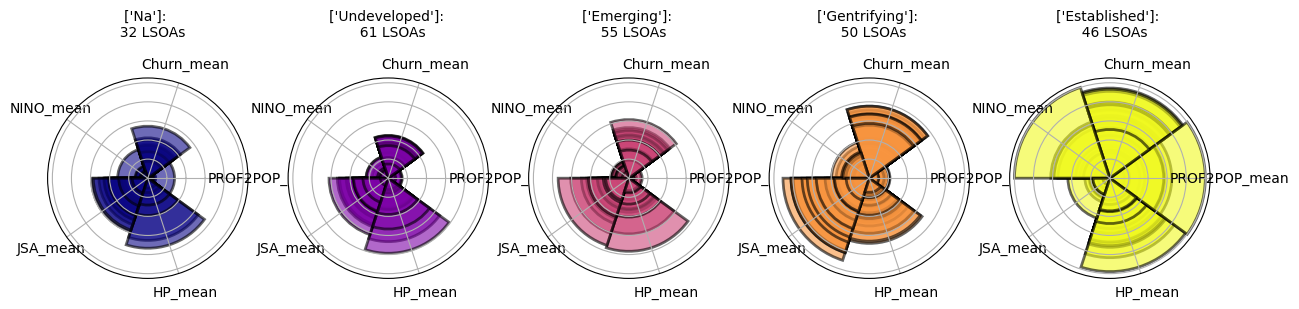

In [17]:
fig, axs = plt.subplots(subplot_kw={'projection': 'polar'}, ncols=5, nrows=1, figsize=(15,10), sharex=True, sharey=True)
for gentr_class, ax in enumerate(axs.flatten()):
    # Filter the data for this gentrification class
    class_data = indicators_bristol_short[indicators_bristol_short['gentrification_prediction_code'] == gentr_class]
    if len(class_data) == 0:
        ax.set_axis_off()
    else:    
        for lsoa in class_data['LSOA11CD']:
            plot_rose(ax,indicators_bristol_short, lsoa, colors[gentr_class])
        key = [k for k, v in mapping.items() if v == gentr_class]
        ax.set_title(f"{key}: \n  {len(class_data)} LSOAs", pad=30, fontsize=10)  

### Plot for one LSOA

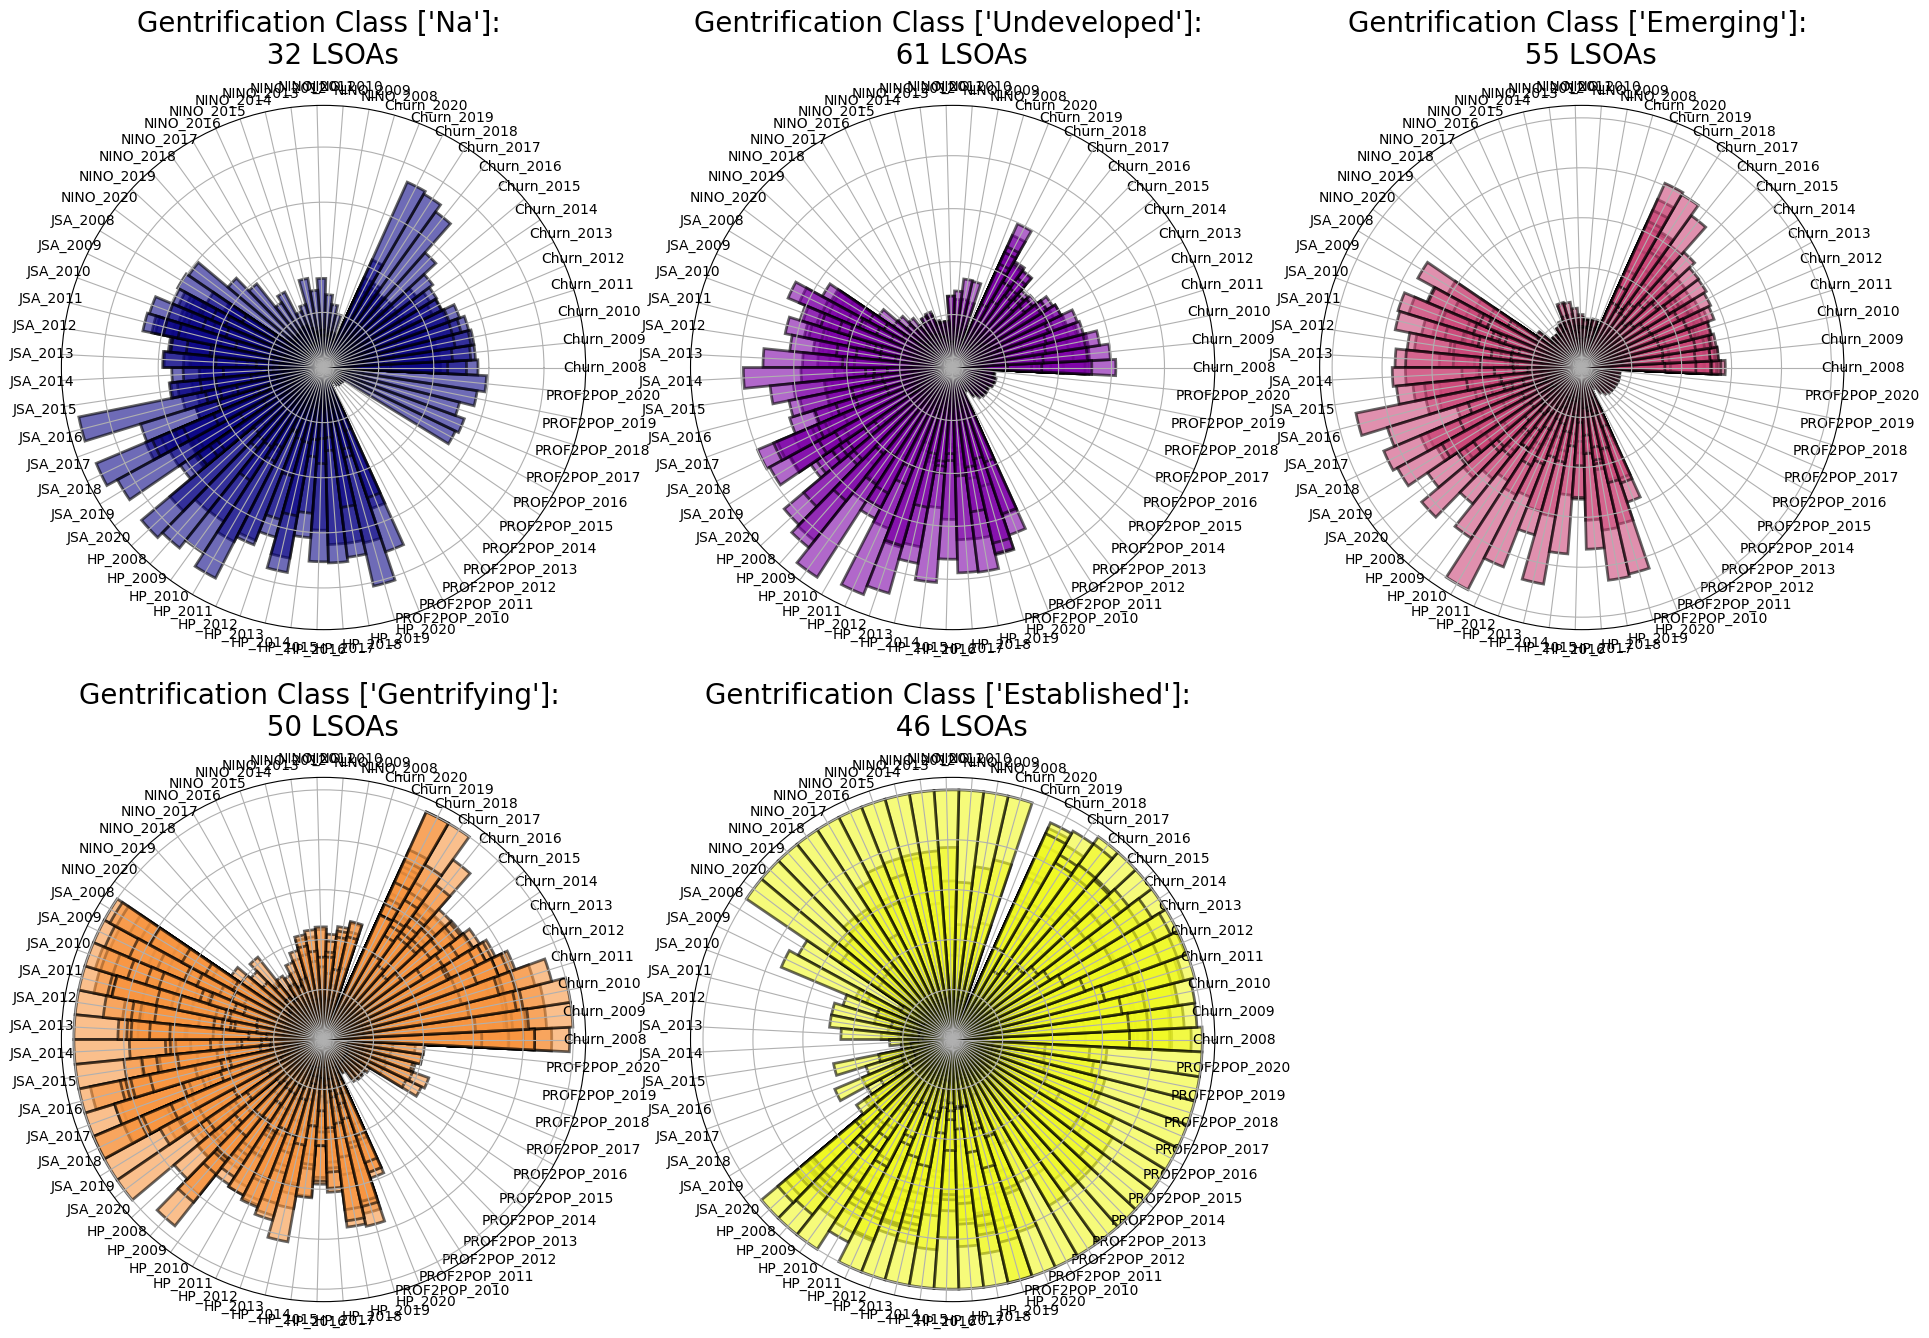

In [18]:
cmap = plt.get_cmap('plasma', 5)  # 5 discrete colors
plot_colors = [cmap(i) for i in range(5)]

fig, axs = plt.subplots(subplot_kw={'projection': 'polar'}, ncols=3, nrows=2, figsize=(23,16))
for gentr_class, ax in enumerate(axs.flatten()):
    # Filter the data for this gentrification class
    class_data = indicators_bristol[indicators_bristol['gentrification_prediction_code'] == gentr_class]
    if len(class_data) == 0:
        ax.set_axis_off()
    else:    
        for lsoa in class_data['LSOA11CD']:
            plot_rose(ax, class_data, lsoa, plot_colors[gentr_class])
        key = [k for k, v in mapping.items() if v == gentr_class]
        ax.set_title(f"Gentrification Class {key}: \n  {len(class_data)} LSOAs", pad=30, fontsize=20)  